####  Submitted By: Lior Kricheli, Eliran Malka and Itamar Yacoby

## Final Project in Deep Learning

### Lecturer - Dr. Jonathan Rubin

#### Holon Institute of Technology - 21.06.2021

###### This project uses the colorectal histology dataset by tensorflow and aims to train a ConvNet model to classify tumorous cells in a biopsy test


In [1]:
pip install patchify 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tifffile as tiff
from sklearn.metrics import confusion_matrix
from seaborn import heatmap 
from sklearn.manifold import TSNE
from patchify import patchify

print(tf.__version__)

2.3.0


# IMPORTANT!
## Choose bellow the right cell to run (Colab or PC)

In [3]:
#USE THIS CELL TO RUN ON COLAB

!git clone https://github.com/ithamar000/DeepLearningFinalProject.git

pathTrain = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/train'
pathTest = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/validation'

In [4]:
# #USE THIS CELL TO RUN ON PC

# pathTrain = 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\train'
# pathTest = 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\validation'

# Part 1: Function Defenitions

#### plot_results(history)

plot the accuracy and loss.

##### history - contains the accuracy and loss of a trained model

In [5]:
def plot_results(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],':r')
    plt.plot(history.history['val_loss'],'.-r')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],':b')
    plt.plot(history.history['val_accuracy'],'b')
    plt.ylim([0, 1])
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

#### plot_confusion_matrix(model, test_generator)
plot a confusion matrix

##### model - The trained model
##### test_generator - the generator used by the model

In [6]:
# Function to plot a confusion matrix

def plot_confusion_matrix(model, test_generator):
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    y_true = true_labels
    y_pred = np.array([np.argmax(x) for x in predictions])
    cm = confusion_matrix(y_true, y_pred)
    CM = cm / cm.sum(axis=1)


    plt.figure(figsize=(10,8))
    heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
    plt.xlabel('Predicted label', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.show()

#### visualize_labelled_data(model, test_generator)

Function to plot a visualization of labelled-data distribution in 2D (Using t-SNE) 

##### model - The trained model
##### test_generator - the generator used by the model

In [7]:
# Function to plot a visualization of labelled-data distribution in 2D (Using t-SNE) 

def visualize_labelled_data(model, test_generator):
    features_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    features = features_extractor.predict(test_generator)

    X_embedded = TSNE(n_components=2).fit_transform(features)
    y = test_generator.classes

    plt.figure(figsize=(10,8))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],80,y, 
                cmap='tab20', alpha=0.7, edgecolors='k')
    plt.colorbar()
    plt.show()

#### get_data_gen(data_augmentation)

Returns data generator

if data_augmentation == True -> applying data augmentation to images

else the images remains in their original condition

##### data_augmentation - boolean to decide if data augmentation is wanted


In [8]:

def get_data_gen(data_augmentation):
    
    my_batch_size = 32  
    
    if(data_augmentation):
        dataGen = ImageDataGenerator(shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     rotation_range=30,
                                     width_shift_range=2,)
        
        train_generator = dataGen.flow_from_directory(pathTrain,
                                                      batch_size=my_batch_size, 
                                                      class_mode='categorical')

        dataGenTest = ImageDataGenerator()
        test_generator = dataGenTest.flow_from_directory(pathTest,                                              
                                                     batch_size=my_batch_size, 
                                                     class_mode='categorical', 
                                                     shuffle=False)
    else:
        dataGen = ImageDataGenerator()
        train_generator = dataGen.flow_from_directory(pathTrain,
                                                      batch_size=my_batch_size, 
                                                      class_mode='categorical')

        dataGenTest = ImageDataGenerator()
        test_generator = dataGenTest.flow_from_directory(pathTest,                                              
                                                     batch_size=my_batch_size, 
                                                     class_mode='categorical', 
                                                     shuffle=False)
    return train_generator,test_generator

#### get_big_model()

Returns a ConvNet Model containing mulitple Conv Layers, Dropout, and Max Pooling



In [9]:
def get_big_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(8, activation = 'softmax'))
    
    return model


#### get_small_model()

Returns a small ConvNet model containing some Conv Layers and Max Pooling without Dropout



In [10]:
def get_small_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
    model.add(MaxPooling2D(pool_size = 3)) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(MaxPooling2D(pool_size = 3)) 
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(8, activation = 'softmax'))
    
    return model

# Part 2: Training Multiple Models

#### In this part we will train three different models with different complexity
#### In the table below you can see the results we achieved with each model

## Summary of results:

<table>
  <tr>
    <th>Model</th>
    <th>#parameters</th>
    <th>epochs</th>
    <th>train accuracy</th>
    <th>test accuracy</th>
  </tr>
    
  <!-- copy this block once for every model you tested -->  
  <tr> 
    <td>> Simple ConvNet </td>   <!-- Model -->
    <td>> 0 </td> <!-- Parameters -->
    <td>> 10 </td> <!-- epochs -->
    <td>> 0.0 </td> <!-- train -->
    <td>> 0.0 </td> <!--  test -->
  </tr>

  <tr> 
    <td>> Simple ConvNet Data Augmentation</td>   <!-- model -->
    <td>> 0 </td> <!-- parameters -->
    <td>> 20 </td> <!-- epochs -->
    <td>> 0.0</td> <!-- train -->
    <td>> 0.0 </td> <!-- test -->
  </tr>

  <tr> 
    <td>> Bigger ConvNet Data Augmentation + Adam optimizer</td>   <!-- model -->
    <td>> 0 </td> <!-- parameters -->
    <td>> 30 </td> <!-- epochs -->
    <td>> 0.0</td> <!-- train -->
    <td>> 0.0 </td> <!-- test -->
  </tr>
    
</table>




In [41]:
#initializing  two sets of data generator, one with augmentaion and one without.

train_generator_original ,test_generator_original = get_data_gen(False)
train_generator_aug, test_generator_aug = get_data_gen(True)


Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.
Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


In [12]:
small_model = get_small_model()
small_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0

In [13]:
small_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 75

small_model_history = small_model.fit(train_generator_original,
                                      steps_per_epoch=train_generator_original.samples/train_generator_original.batch_size, 
                                      validation_data=test_generator_original,
                                      epochs=epochs, batch_size=20, verbose=1)

Epoch 1/50
141/140 [==============================] - 45s 322ms/step - loss: 5.2239 - accuracy: 0.3952 - val_loss: 1.3601 - val_accuracy: 0.4435
Epoch 2/50
141/140 [==============================] - 45s 317ms/step - loss: 1.0685 - accuracy: 0.5870 - val_loss: 0.9684 - val_accuracy: 0.5907
Epoch 3/50
141/140 [==============================] - 45s 317ms/step - loss: 0.8369 - accuracy: 0.6725 - val_loss: 0.7136 - val_accuracy: 0.7258
Epoch 4/50
141/140 [==============================] - 46s 326ms/step - loss: 0.7126 - accuracy: 0.7294 - val_loss: 0.6689 - val_accuracy: 0.7056
Epoch 5/50
141/140 [==============================] - 46s 329ms/step - loss: 0.6257 - accuracy: 0.7658 - val_loss: 0.6705 - val_accuracy: 0.7540
Epoch 6/50
141/140 [==============================] - 45s 318ms/step - loss: 0.5853 - accuracy: 0.7860 - val_loss: 0.5540 - val_accuracy: 0.7863
Epoch 7/50
141/140 [==============================] - 47s 333ms/step - loss: 0.5416 - accuracy: 0.7942 - val_loss: 0.4468 - val_ac

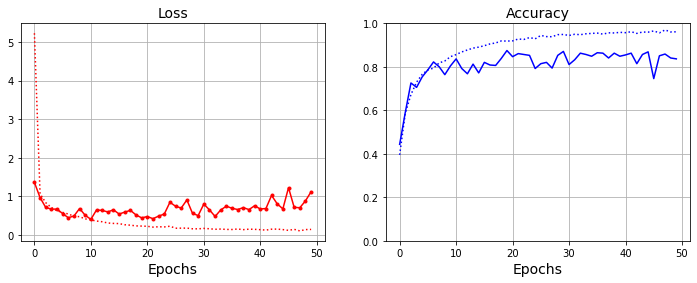

In [14]:
plot_results(small_model_history)

In [15]:
small_model_aug = get_small_model()
small_model_aug.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 75

small_model_aug_history = small_model_aug.fit(train_generator_aug,
                                      steps_per_epoch=train_generator_aug.samples/train_generator_aug.batch_size, 
                                      validation_data=test_generator_aug,
                                      epochs=epochs, batch_size=20, verbose=1)

Epoch 1/100
141/140 [==============================] - 75s 535ms/step - loss: 3.9331 - accuracy: 0.4139 - val_loss: 1.2474 - val_accuracy: 0.5585
Epoch 2/100
141/140 [==============================] - 76s 536ms/step - loss: 1.0252 - accuracy: 0.6039 - val_loss: 0.9692 - val_accuracy: 0.6149
Epoch 3/100
141/140 [==============================] - 78s 556ms/step - loss: 0.8878 - accuracy: 0.6594 - val_loss: 0.8961 - val_accuracy: 0.6633
Epoch 4/100
141/140 [==============================] - 80s 568ms/step - loss: 0.7843 - accuracy: 0.6938 - val_loss: 0.6839 - val_accuracy: 0.7379
Epoch 5/100
141/140 [==============================] - 78s 552ms/step - loss: 0.6981 - accuracy: 0.7362 - val_loss: 0.6333 - val_accuracy: 0.7944
Epoch 6/100
141/140 [==============================] - 75s 533ms/step - loss: 0.6860 - accuracy: 0.7405 - val_loss: 1.2349 - val_accuracy: 0.6310
Epoch 7/100
141/140 [==============================] - 81s 572ms/step - loss: 0.6429 - accuracy: 0.7669 - val_loss: 0.7401 -

Epoch 57/100
141/140 [==============================] - 71s 501ms/step - loss: 0.3444 - accuracy: 0.8759 - val_loss: 0.3505 - val_accuracy: 0.8810
Epoch 58/100
141/140 [==============================] - 71s 501ms/step - loss: 0.3486 - accuracy: 0.8837 - val_loss: 0.3587 - val_accuracy: 0.8952
Epoch 59/100
141/140 [==============================] - 71s 502ms/step - loss: 0.3461 - accuracy: 0.8783 - val_loss: 0.4540 - val_accuracy: 0.8548
Epoch 60/100
141/140 [==============================] - 70s 500ms/step - loss: 0.3763 - accuracy: 0.8701 - val_loss: 0.3539 - val_accuracy: 0.8790
Epoch 61/100
141/140 [==============================] - 71s 501ms/step - loss: 0.3395 - accuracy: 0.8808 - val_loss: 0.4401 - val_accuracy: 0.8851
Epoch 62/100
141/140 [==============================] - 70s 500ms/step - loss: 0.3578 - accuracy: 0.8757 - val_loss: 0.4300 - val_accuracy: 0.8589
Epoch 63/100
141/140 [==============================] - 71s 500ms/step - loss: 0.3638 - accuracy: 0.8801 - val_loss: 0

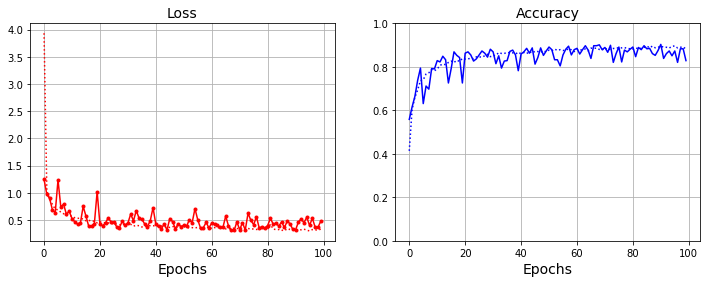

In [16]:
plot_results(small_model_aug_history)

In [17]:
big_model_aug = get_big_model()
big_model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)       

In [18]:
big_model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 75

big_model_aug_history = big_model_aug.fit(train_generator_aug, steps_per_epoch=train_generator_aug.samples/train_generator_aug.batch_size, 
          validation_data=test_generator_aug,
          epochs=epochs, batch_size=20, verbose=1)

Epoch 1/200
141/140 [==============================] - 262s 2s/step - loss: 1.6442 - accuracy: 0.3679 - val_loss: 1.4357 - val_accuracy: 0.4798
Epoch 2/200
141/140 [==============================] - 265s 2s/step - loss: 1.0008 - accuracy: 0.5671 - val_loss: 1.2823 - val_accuracy: 0.6190
Epoch 3/200
141/140 [==============================] - 265s 2s/step - loss: 0.8005 - accuracy: 0.6852 - val_loss: 1.1529 - val_accuracy: 0.6714
Epoch 4/200
141/140 [==============================] - 266s 2s/step - loss: 0.7798 - accuracy: 0.6976 - val_loss: 1.4085 - val_accuracy: 0.4859
Epoch 5/200
141/140 [==============================] - 268s 2s/step - loss: 0.7015 - accuracy: 0.7331 - val_loss: 1.0510 - val_accuracy: 0.6976
Epoch 6/200
141/140 [==============================] - 267s 2s/step - loss: 0.6618 - accuracy: 0.7462 - val_loss: 1.0426 - val_accuracy: 0.7560
Epoch 7/200
141/140 [==============================] - 268s 2s/step - loss: 0.6352 - accuracy: 0.7624 - val_loss: 0.9320 - val_accuracy:

141/140 [==============================] - 265s 2s/step - loss: 0.2009 - accuracy: 0.9278 - val_loss: 0.4060 - val_accuracy: 0.8669
Epoch 114/200
141/140 [==============================] - 265s 2s/step - loss: 0.2032 - accuracy: 0.9263 - val_loss: 0.4325 - val_accuracy: 0.8569
Epoch 115/200
141/140 [==============================] - 266s 2s/step - loss: 0.1844 - accuracy: 0.9318 - val_loss: 0.5494 - val_accuracy: 0.8044
Epoch 116/200
141/140 [==============================] - 266s 2s/step - loss: 0.2282 - accuracy: 0.9176 - val_loss: 0.5015 - val_accuracy: 0.8266
Epoch 117/200
141/140 [==============================] - 265s 2s/step - loss: 0.1912 - accuracy: 0.9301 - val_loss: 0.4844 - val_accuracy: 0.8407
Epoch 118/200
141/140 [==============================] - 266s 2s/step - loss: 0.1992 - accuracy: 0.9285 - val_loss: 0.6346 - val_accuracy: 0.7742
Epoch 119/200
141/140 [==============================] - 265s 2s/step - loss: 0.2006 - accuracy: 0.9256 - val_loss: 0.3591 - val_accuracy:

# Part 2.1: Visualizing the results of our best model

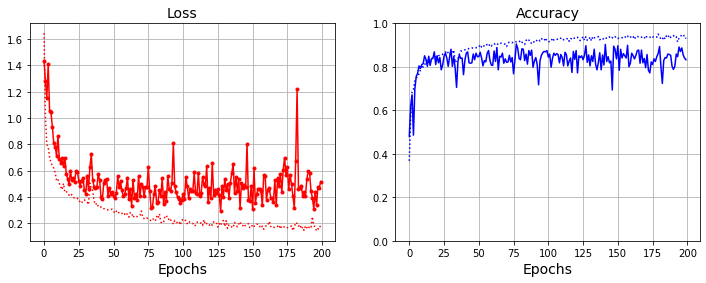

In [19]:
plot_results(big_model_aug_history)

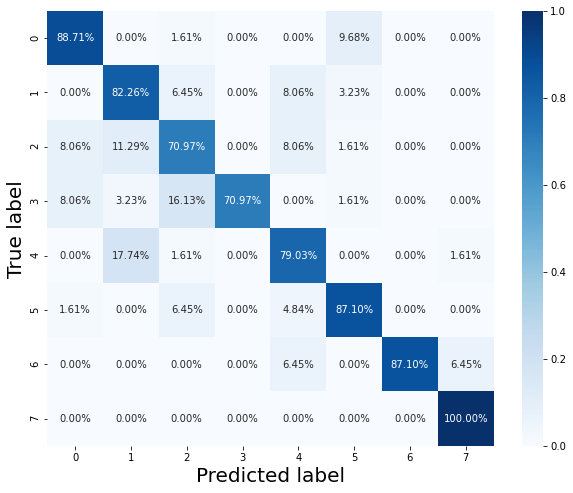

In [20]:
plot_confusion_matrix(big_model_aug,test_generator_aug)

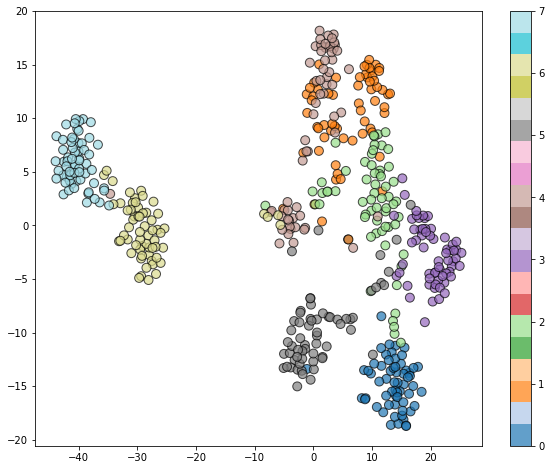

In [21]:
visualize_labelled_data(big_model_aug, test_generator_aug)

# Part 3: Image Segmentation

#### In this part we will use the trained model to classify small patches of a large image to help detect tumors
#### We will also show the probability of each cell to be tumorous

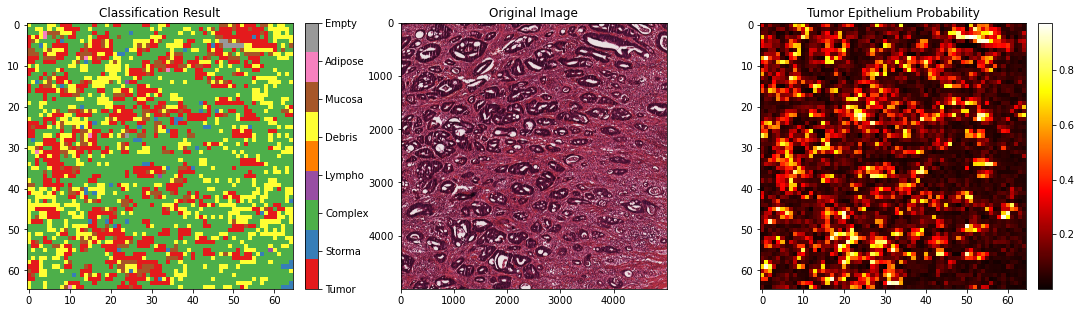

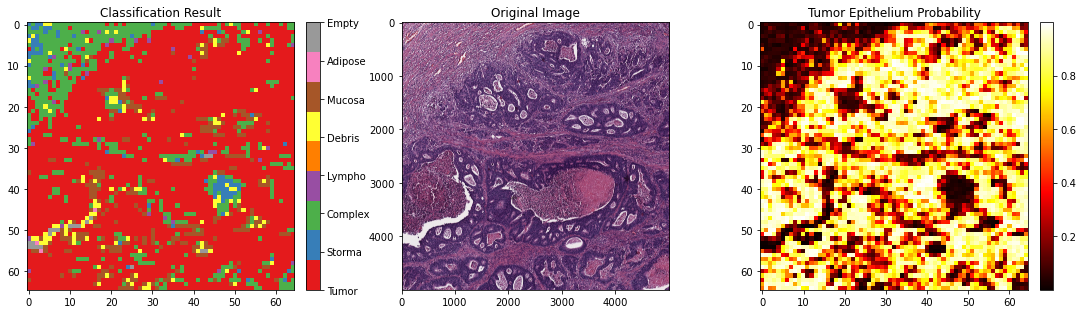

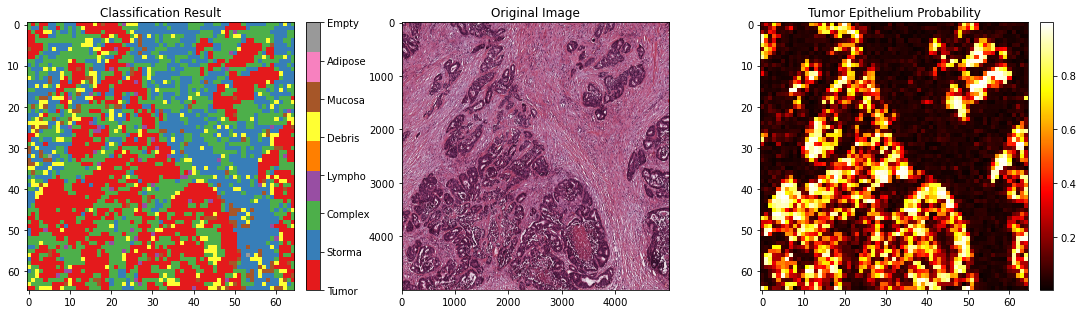

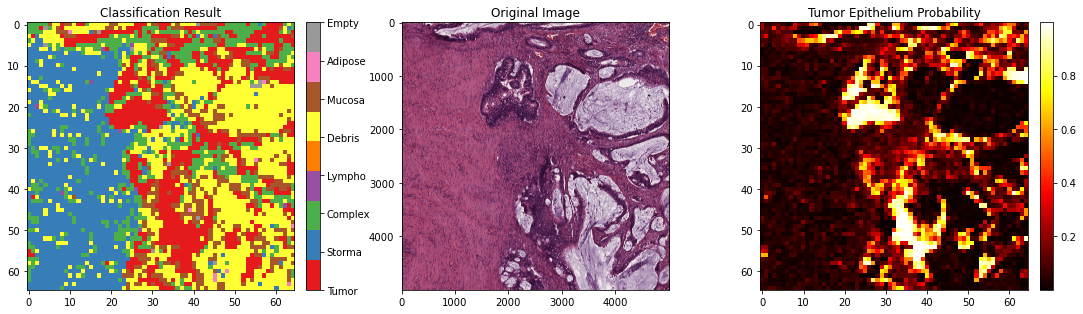

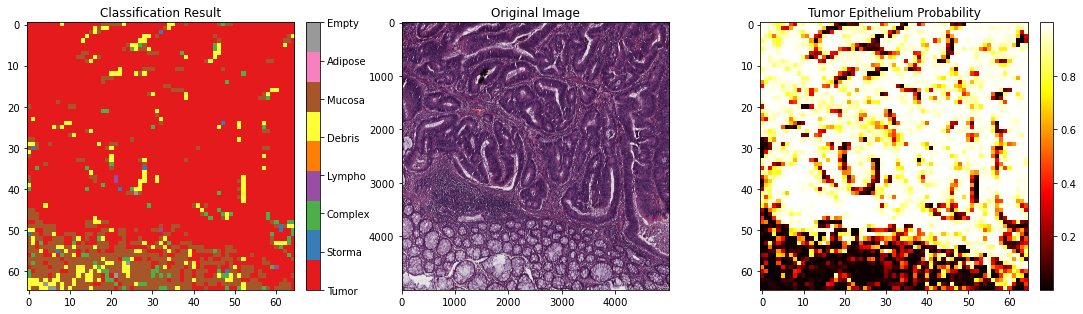

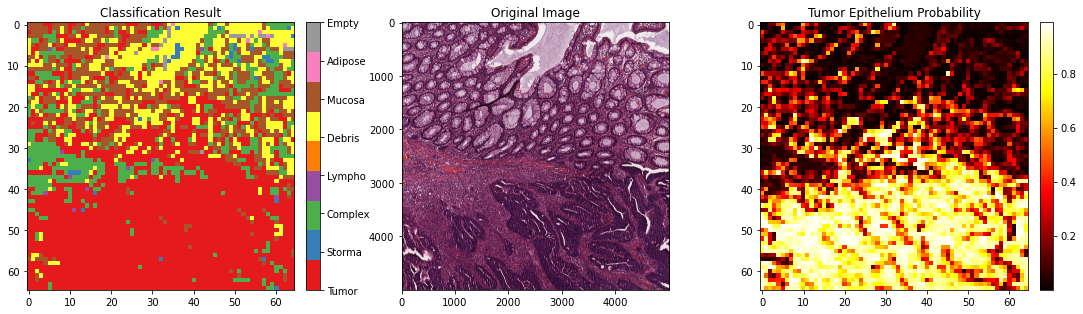

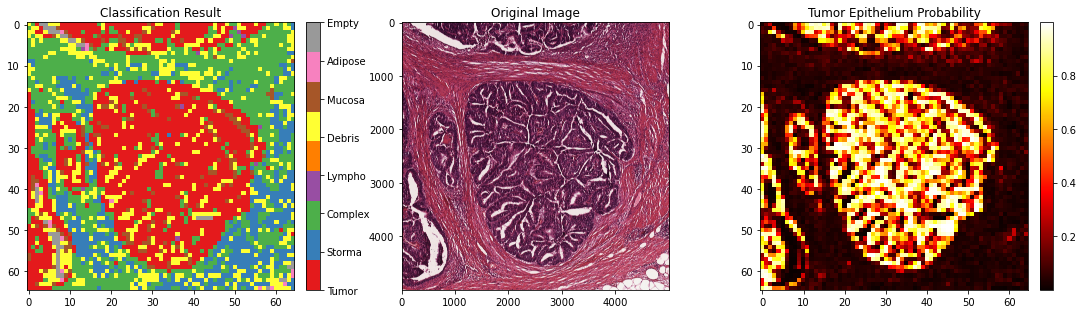

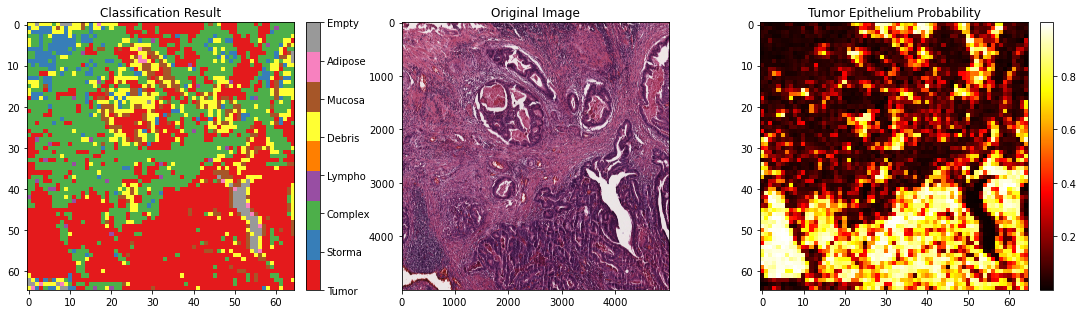

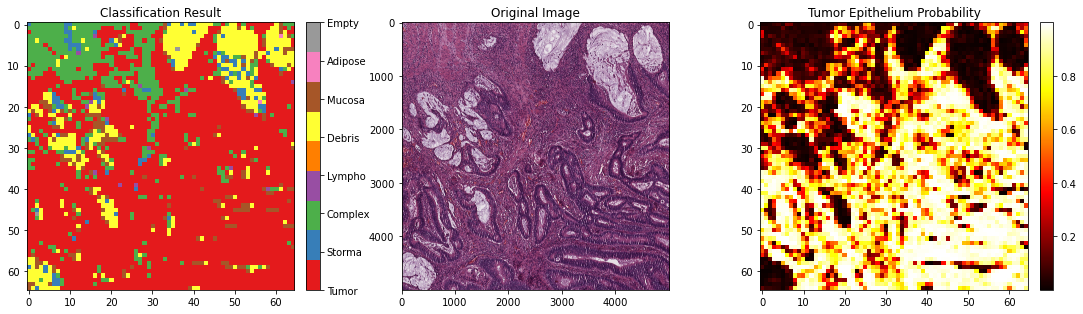

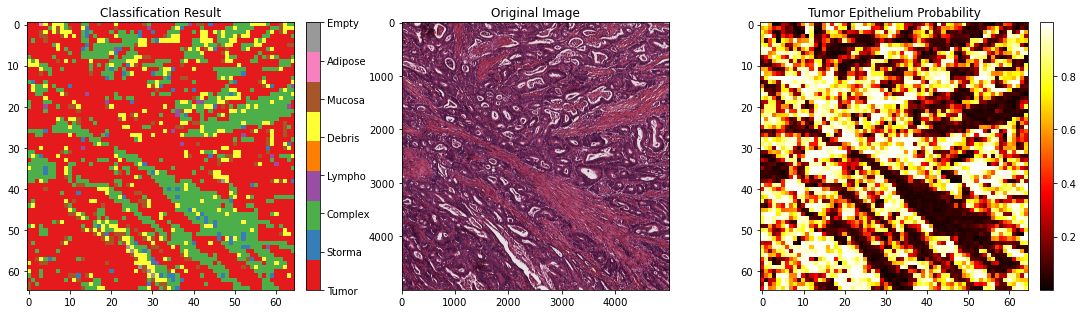

In [22]:
for x in range(1,11):
    
# IMPORTANT! choose to right path according (Colab or PC)

    #Colab section
    path = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_larger_images_10/Kather_texture_2016_larger_images_10/CRC-Prim-HE-0'+str(x)+'_APPLICATION.tif'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #End of Colab section

    #PC ection
#     path = 'archive\Kather_texture_2016_larger_images_10\Kather_texture_2016_larger_images_10\CRC-Prim-HE-0'+str(x)+'_APPLICATION.tif'
#     image = tiff.imread(path)
    #End of PC section

    patches = patchify(image, (150, 150, 3), step=75) #Split image to small patches
    patches_shape = patches.shape
    colored_patches = np.zeros((patches_shape[0],patches_shape[1])) #Create the label-colored image
    tumor_prob = np.zeros((patches_shape[0],patches_shape[1])) #Create the probability image
    
    for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                yhat = big_model_aug.predict(single_patch) 
                colored_patches[i,j] = np.argmax(yhat) #argmax returs the index with the highest score
                tumor_prob[i,j] = yhat[0,0] #[0,0]contains the probabilty for the patch to contain tumouros cells
    
    fig = plt.figure(figsize=(15, 45))
    plt.subplot(11,3,3*x-2)
    plt.title("Classification Result")
    plt.imshow(colored_patches,cmap='Set1')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_ticks([0,1,2,3,4,5,6,7])
    cbar.set_ticklabels(['Tumor', 'Storma','Complex','Lympho','Debris','Mucosa','Adipose','Empty'])

    plt.subplot(11,3,3*x-1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(11,3,3*x)
    plt.title("Tumor Epithelium Probability")
    plt.imshow(tumor_prob,cmap='hot')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    
    fig.tight_layout()


# Part 4: Used Resources:



In [42]:
# https://www.kaggle.com/kmader/colorectal-histology-mnist

# Various jupyter notebooks and lectures by Dr. Jonathan Rubin

# https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w/featured